In [1]:
import pytorch_lightning as pl
import torch as pt

# MUST import tensorflow SECOND or else you will encounter ambiguous error!
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import ChemtabUQ

2023-09-20 18:10:45.339273: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-20 18:10:45.371359: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-20 18:10:45.974699: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
from glob import glob
print(os.getcwd())
print(glob('../CT_logs_Mu/PCA-CT/*/checkpoints/*'))

/project/dwyer/home/CTV2_master/ChemtabUQ
[]


In [50]:
from torch import nn
import torch.nn.functional as F
import torchmetrics.functional as F_metrics

def make_MLP(input_size, output_size):
    hidden_size = input_size*4
    n_layers = 4
    bulk_layers = []
    for i in range(n_layers-1): # this should be safer then potentially copying layers by reference...
        bulk_layers.extend([nn.SELU(), nn.Linear(hidden_size,hidden_size)])
    regressor = nn.Sequential(nn.BatchNorm1d(input_size),nn.Linear(input_size,hidden_size),*bulk_layers, nn.Linear(hidden_size, output_size))
    return regressor
mlp_pt = make_MLP(25, 25)

In [54]:
PL_module = mlp_pt

#ckpt_path='../CT_logs_Mu/PCA-CT/version_13420073/checkpoints/epoch=10438-step=10439.ckpt'
#PL_module = ChemtabUQ.FFRegressor.load_from_checkpoint(ckpt_path, input_size=25)
##inputs = PL_module.example_input_array
##in_shape=inputs.shape

in_shape = (8,25)
inputs = pt.randn(*in_shape).cpu()

In [55]:
target_outputs = PL_module.cpu().forward(inputs).detach().cpu().numpy()
test_inputs=inputs.cpu().detach().numpy()

In [56]:
"""
torch.onnx.export(torch_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "super_resolution.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})
"""

import os
from torch.onnx import TrainingMode
%pdb on

onnx_model_path = os.path.dirname(ckpt_path)+'/model.onnx'
try: os.remove(onnx_model_path)
except: None
print('saving to :', onnx_model_path)

PL_module.to_onnx(onnx_model_path, export_params=True, #training=TrainingMode.TRAINING,
                  input_names=['input'], output_names=['output'], do_constant_folding=False,
                  dynamic_axes={'input' : {0 : 'batch_size'}, # variable length axes
                                'output' : {0 : 'batch_size'}})

Automatic pdb calling has been turned ON
saving to : ../CT_logs_Mu/PCA-CT/version_13420073/checkpoints/model.onnx


AttributeError: 'Sequential' object has no attribute 'to_onnx'

> /project/dwyer/home/mambaforge/envs/CTV2/lib/python3.9/site-packages/torch/nn/modules/module.py(1614)__getattr__()
   1612             if name in modules:
   1613                 return modules[name]
-> 1614         raise AttributeError("'{}' object has no attribute '{}'".format(
   1615             type(self).__name__, name))
   1616 



ipdb>  q


In [45]:
import onnx
from onnx_tf.backend import prepare
print('onnx_model_path: ', onnx_model_path)
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)
tf_rep = prepare(onnx_model)
tf_model_path = os.path.dirname(ckpt_path)+'/model_TF'
tf_rep.export_graph(tf_model_path)
#print(onnx_model)

onnx_model_path:  ../CT_logs_Mu/PCA-CT/version_13420073/checkpoints/model.onnx
INFO:tensorflow:Assets written to: ../CT_logs_Mu/PCA-CT/version_13420073/checkpoints/model_TF/assets


INFO:tensorflow:Assets written to: ../CT_logs_Mu/PCA-CT/version_13420073/checkpoints/model_TF/assets


recon mae:  139.19832


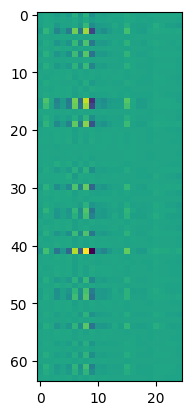

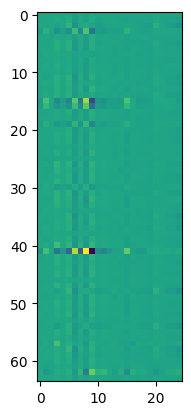

In [46]:
import onnxruntime as ort
import numpy as np

ort_sess = ort.InferenceSession(onnx_model_path, providers=['CPUExecutionProvider'])
onnx_outputs = ort_sess.run(None, {'input': test_inputs})[0]
mae = np.mean(np.abs(onnx_outputs-target_outputs))

print('recon mae: ', mae)

import matplotlib.pyplot as plt
plt.imshow(onnx_outputs)
plt.show()
plt.imshow(target_outputs)
plt.show()

Automatic pdb calling has been turned OFF


recon mae:  tf.Tensor(139.1983, shape=(), dtype=float32)


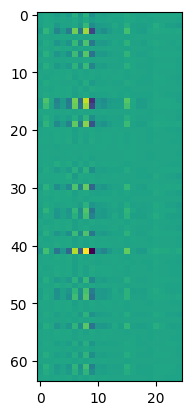

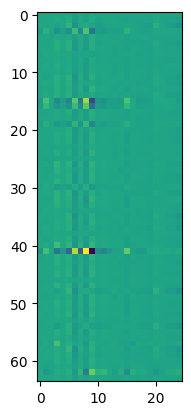

In [47]:
%pdb off
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers as L
#in_shape=(8,25)
#x=tf.ones(shape=in_shape)
keras_version = keras.models.load_model(tf_model_path)
actual_output=keras_version(input=test_inputs)['output']
#print('sample output: ', actual_output)
mae=tf.reduce_mean(tf.math.abs(actual_output-target_outputs))
print('recon mae: ', mae)

import matplotlib.pyplot as plt
plt.imshow(actual_output)
plt.show()
plt.imshow(target_outputs)
plt.show()

In [ ]:
#output = input = L.Input(in_shape[1:])
#output = L.Dense(64, activation='selu', name='in_wrapping_layer')(output)
#output = keras_version(input=output)['output']
#output = L.Dense(64, activation='selu', name='out_wrapping_layer')(output)
#keras_wrapper = keras.models.Model(inputs=input, outputs=output)
##keras_wrapper = keras.models.Sequential()
##keras_wrapper.add(L.Dense(64, activation='selu', name='in_wrapping_layer'))
#keras_wrapper.summary()